# Proyecto 2 Mineria de Datos
## Predicción de Indices de Precios al Consumidor
---
**Integrantes**
- Maria Marta Ramirez Gil
- Gustavo Andres Gonzalez Pineda 
- Diego Alberto Leiva Pérez 
- José Pablo Orellana Orellana 
- Gabriel Estuardo García Donis 
---

**Importar Librerias**

In [1]:
# Manipulacion de datos
import pandas as pd

# Librerias para visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Librerias para division de datos
from sklearn.model_selection import train_test_split

# Librerias para modelado de algoritmos
from sklearn.linear_model import LinearRegression

# Libreria de metricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

**Cargar el Dataset**

In [2]:
dataframe = pd.read_csv('IPC_CLEAN.csv')

**Visualizar estructura e información general del dataset**

In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42139 entries, 0 to 42138
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   codigo       42139 non-null  int64  
 1   descripcion  42139 non-null  object 
 2   pais         42139 non-null  float64
 3   region1      42139 non-null  float64
 4   region2      42139 non-null  float64
 5   region3      42139 non-null  float64
 6   region5      42139 non-null  float64
 7   region6      42139 non-null  float64
 8   region7      42139 non-null  float64
 9   region8      42139 non-null  float64
 10  fecha        42139 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 3.5+ MB


In [4]:
for value, name in zip(dataframe.shape,['Registros', 'Variables']):
    print(f'Cantidad de {name}: {value}')

Cantidad de Registros: 42139
Cantidad de Variables: 11


In [5]:
dataframe.head()

,codigo,descripcion,pais,region1,region2,region3,region5,region6,region7,region8,fecha
0,0,indice general,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01
1,1,alimentos y bebidas no alcoholicas ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01
2,111101,arroz ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01
3,111201,harina ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01
4,111202,maiz ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01


**Variables Identificadas:**
- codigo: Identificador numérico para cada producto o categoría de productos.
- descripcion: Detalle sobre el producto o categoría de productos al que se refiere el índice de precios.
- pais: Valor representativo para todo el país
- region1: Valor representativo de la región Metropolitana.
- region2: Valor representativo de la región Norte.
- region3: Valor representativo de la región Nororiental.
- region5: Valor representativo de la región Central.
- region6: Valor representativo de la región Suroccidental.
- region7: Valor representativo de la región Noroccidental.
- region8: Valor representativo de la región Petén.
---

## Selección de Variable Respuesta

La variable de respuesta seleccionada es la variable de `pais`.

Esta variable representa el Índice de Precios al Consumidor (IPC) a nivel nacional para Guatemala. Elegir esta variable permite modelar y predecir la tendencia general de la inflación y los cambios de precios en todo el país. Esto es útil para entender la economía a gran escala y para formular políticas económicas que impacten a toda la nación.

Sin embargo, dada la estructura del dataset es posible realizar otro tipo de seleccion y predicciones de variables, en este caso la prediccion por `region_N` (donde N puede ser cualquier número de 1 a 8, dependiendo de la región de interés) Cada columna `region_N` representa el IPC para una región específica de Guatemala. Seleccionar una de estas variables permite realizar predicciones específicas para una región determinada, lo cual es crucial para políticas regionales y para entender cómo diferentes partes del país se comportan en términos de cambios en los precios. Esto puede ayudar a identificar regiones con necesidades económicas particulares o con dinámicas de mercado únicas.

---

### Preprocesamiento de datos

**Conversión de Fecha a dato numérico**

Es necesario convertir la columna de fecha (variable categórica) a dato numérico ya que la fecha es la variable que indica como el IPC cambia a lo largo del tiempo. Sin esta conversión no es posible tomar el factor tiempo en consideración dentro del modelo, lo cual puede provocar predicciones erroneas.

In [6]:
# Realizar una copia del dataframe
data = dataframe.copy()

# Convertir 'fecha' a años y meses asi son datos numericos
data['fecha'] = pd.to_datetime(data['fecha'])
data['anio'] = data['fecha'].dt.year
data['mes'] = data['fecha'].dt.month

# Mostrar el dataframe con las nuevas columnas
data.head()

,codigo,descripcion,pais,region1,region2,region3,region5,region6,region7,region8,fecha,anio,mes
0,0,indice general,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01,2010,12
1,1,alimentos y bebidas no alcoholicas ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01,2010,12
2,111101,arroz ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01,2010,12
3,111201,harina ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01,2010,12
4,111202,maiz ...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2010-12-01,2010,12


## Modelos

**Funciones Necesarias**

In [7]:
def get_metrics(model, x_test, y_test):
    """
    Calcula y devuelve los valores predichos, el error cuadrático medio (MSE), el error absoluto 
    medio (MAE) y el coeficiente de determinación (R2) para un modelo dado.
    
    Args:
        - model (object): El modelo entrenado utilizado para la predicción.
        - x_test (array): Las variables de entrada para el conjunto de pruebas.
        - y_test (array): Los valores reales para el conjunto de pruebas.

    Returns:
        - y_pred (array): Los valores objetivo predichos.
        - mse (float):  El error cuadrático medio entre los valores objetivo reales y predichos.
        - mae (float): El error absoluto medio entre los valores objetivo reales y predichos.
        - r2 (float): El valor R cuadrado entre los valores objetivo reales y predichos.
    """
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_pred, mse, mae, r2

In [8]:
def show_metrics(mse, mae, r2):
    """
    Muestra las métricas de evaluación para un modelo de regresión.

    Args:
        - mse (float): Error Cuadrático Medio.
        - mae (float): Error Absoluto Medio.
        - r2 (float): Puntuación R2.

    Returns:
        - None
    """
    print('-'*10,' Métricas ','-'*10)
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R2 Score: {r2}')

In [9]:
def plot_predictions(ax, y_test, y_pred, title=''):
    """
    Grafica los valores IPC predichos frente a los valores IPC reales.

    Args:
        - ax (matplotlib.axes.Axes): Objeto de ejes de matplotlib para graficar.
        - y_test (array): Los valores IPC reales.
        - y_pred (array): Los valores IPC predichos.
        - title (str, opcional): Título para el gráfico. Por defecto es una cadena vacía.

    Returns:
        - None
    """
    ax.scatter(y_test, y_pred, alpha=0.7, label='Datos de prueba')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4, label='Recta de regresión')
    ax.set_xlabel('IPC Real')
    ax.set_ylabel('IPC Predicho')
    ax.set_title(f'IPC Real vs IPC Predicho {title}')
    ax.legend()

In [10]:
def plot_residuals(ax, y_test, y_pred, title=''):
    """
    Grafica los residuos de un modelo de regresión.

    Args:
        - ax (matplotlib.axes.Axes): El objeto de ejes para graficar.
        - y_test (array): Los valores reales de la variable objetivo.
        - y_pred (array): Los valores predichos de la variable objetivo.
        - title (str, opcional): El título del gráfico. Por defecto, es una cadena vacía.

    Returns:
        - None
    """
    residuals = y_test - y_pred
    ax.scatter(y_test, residuals, alpha=0.7, label='Residuales')
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('IPC Real')
    ax.set_ylabel('Residuos')
    ax.set_title(f'Residuales vs IPC Real {title}')
    ax.legend()

In [11]:
def plot_density_residuals(ax, residuals, title=''):
    """
    Grafica la densidad y el histograma de los residuos.

    Args:
        - ax (matplotlib.axes.Axes): El objeto de ejes para graficar.
        - residuals (array): Los residuos que se van a graficar.
        - title (str, opcinal): El título del gráfico. Por defecto, es una cadena vacía.

    Returns:
        - None
    """
    sns.histplot(residuals, kde=True, bins=30, color='blue', ax=ax)
    ax.set_title(f'Densidad e histograma de Residuales {title}')
    ax.set_xlabel('Residuos')
    ax.set_ylabel('Conteo')

In [12]:
def plot_model(y_test, y_pred, title=''):
    """
    Grafica las predicciones del modelo, los residuos y la densidad de los residuos.

    Args:
        - y_test (array): Los valores reales de la variable objetivo.
        - y_pred (array): Los valores predichos de la variable objetivo.
        - title (str, opcional): El título del gráfico. Por defecto, es una cadena vacía.

    Returns:
        - None
    """
    fig, axs = plt.subplots(1, 3, figsize=(22, 6))
    plot_predictions(axs[0], y_test, y_pred, title)
    plot_residuals(axs[1], y_test, y_pred, title)
    plot_density_residuals(axs[2], y_test - y_pred, title)

### Regresión Lineal con Split aleatorio
- Variable Respuesta `IPC Nacional`

**División del Dataset**

In [13]:
# Seleccion de variable objetivo y variables predictoras
X = data[['region1', 'region2', 'region3', 'region5', 'region6', 'region7', 'region8', 'anio', 'mes']]
y = data['pais']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


**Entrenamiento y Evaluación del Modelo**

In [14]:
# Inicializar el modelo y entrenarlo con los datos de entrenamiento
model = LinearRegression()
model.fit(X_train, y_train)

# Obtener las predicciones y las métricas
y_pred, mse, mae, r2 = get_metrics(model, X_test, y_test)
show_metrics(mse, mae, r2)

----------  Métricas  ----------
Mean Squared Error (MSE): 44.10251550303405
Mean Absolute Error (MAE): 2.9533276144519185
R2 Score: 0.9045125218850901


**Gráficas**

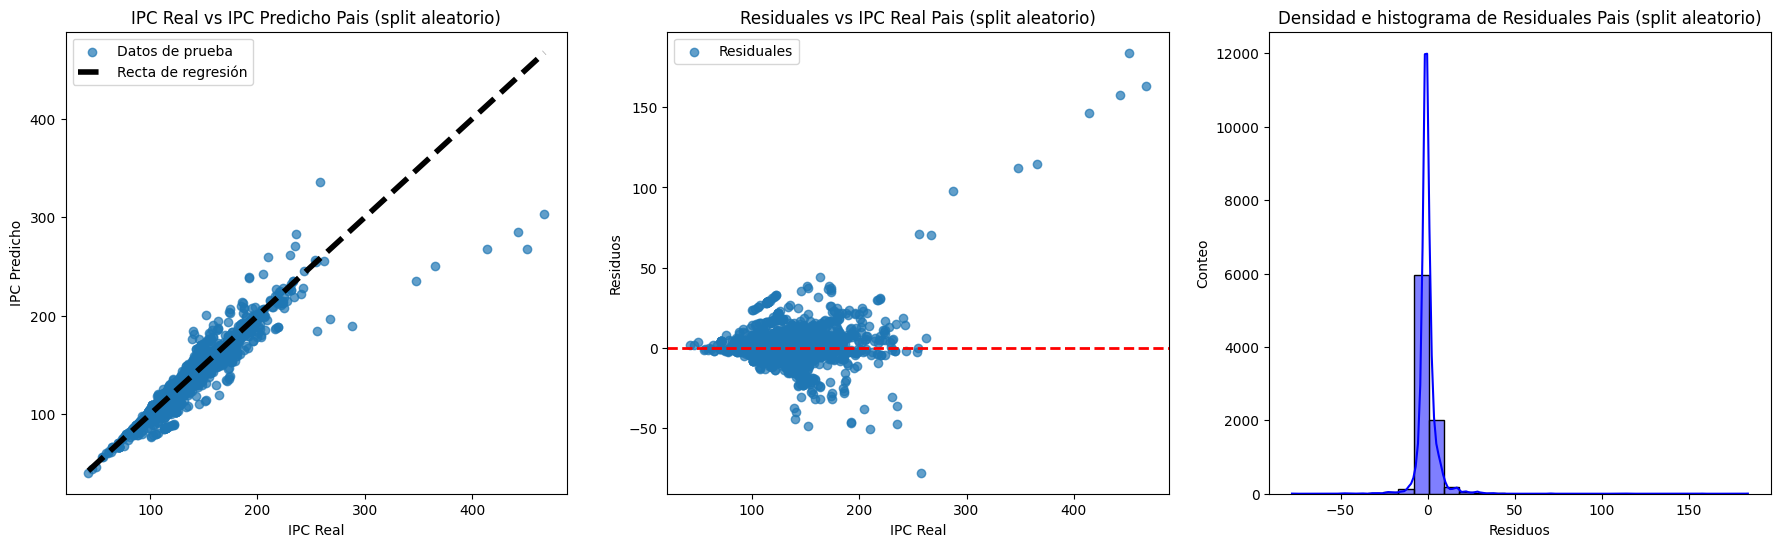

In [15]:
# Graficar el modelo
plot_model(y_test, y_pred, 'Pais (split aleatorio)')

### Regresión Lineal con Split basado en tiempo
- Variable Respuesta `IPC Nacional`

**División del Dataset**

In [16]:
# Ordenar los datos por fecha
data_sorted = data.sort_values(by='fecha')

# Definir el índice de división de los datos
split_index = int(len(data_sorted) * 0.8)

# Dividir los datos en entrenamiento y prueba basado en el tiempo
X_train_time = data_sorted.iloc[:split_index][['region1', 'region2', 'region3', 'region5', 'region6', 'region7', 'region8', 'anio', 'mes']]
y_train_time = data_sorted.iloc[:split_index]['pais']
X_test_time = data_sorted.iloc[split_index:][['region1', 'region2', 'region3', 'region5', 'region6', 'region7', 'region8', 'anio', 'mes']]
y_test_time = data_sorted.iloc[split_index:]['pais']


**Entrenamiento y Evaluación del Modelo**

In [17]:
# Inicializar y entrenar el modelo con los datos de entrenamiento basados en el tiempo
model_time = LinearRegression()
model_time.fit(X_train_time, y_train_time)

# Obtener las predicciones y las métricas basadas en el tiempo
y_pred_time, mse_time, mae_time, r2_time = get_metrics(model_time, X_test_time, y_test_time)
show_metrics(mse_time, mae_time, r2_time)

----------  Métricas  ----------
Mean Squared Error (MSE): 41.828676611172675
Mean Absolute Error (MAE): 4.095831201386473
R2 Score: 0.9214473288879494


**Gráficas**

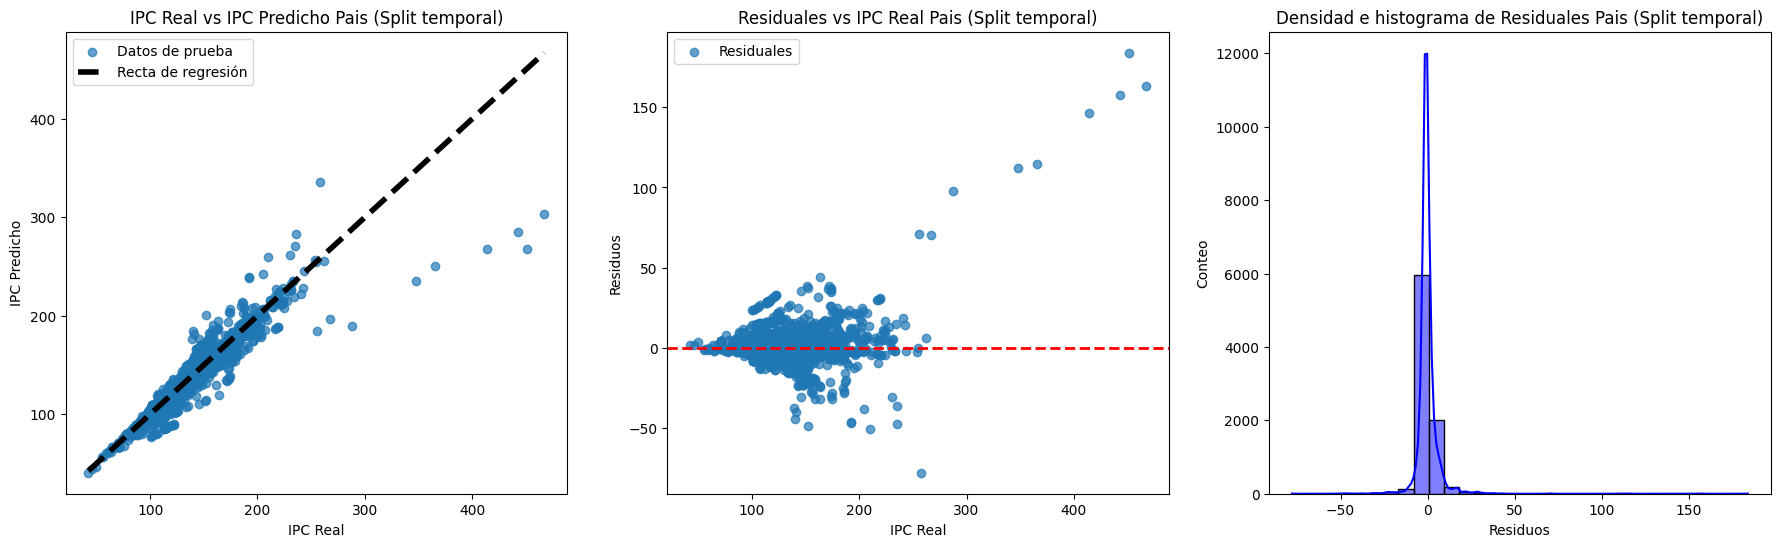

In [18]:
# Graficar el modelo basado en el tiempo
plot_model(y_test, y_pred, 'Pais (Split temporal)')

### Regresión Lineal
- Variable respuesta `IPC Region`

In [19]:
def predict_ipc_for_region(region_name, data):
    """
    Predice el IPC (Índice de Precios al Consumidor) para una región específica utilizando regresión lineal.

    Args:
        - region_name (str): El nombre de la región para la cual predecir el IPC.
        - data (pandas.DataFrame): Los datos de entrada que contienen las variables predictoras y la variable objetivo.

    Returns:
        - model (object): El modelo entrenado. 
        - X_test (array): Las variables de entrada para el conjunto de pruebas.
        - y_test (array): Los valores reales para el conjunto de pruebas.
    """

    # Excluir la variable objetivo de los predictores y crear la lista de predictores
    predictors = [col for col in data.columns if col.startswith('region') and col != region_name] + ['anio', 'mes']
    target = region_name
    
    # Ordenar los datos por fecha
    data_sorted = data.sort_values(by='fecha')
    X = data_sorted[predictors]
    y = data_sorted[target]
    
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Entrenar el modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    return model, X_test, y_test

In [20]:
def region_models(data, features):
    """
    Entrena y evalúa modelos de predicción de IPC para diferentes regiones.

    Args:
        - data (DataFrame): Los datos de entrada que contienen los valores IPC para diferentes regiones.
        - features (list): La lista de regiones para entrenar los modelos.

    Returns:
        - None
    """
    fig, axs = plt.subplots(len(features), 3, figsize=(20, 6 * len(features)))
    regions = {'region1': 'Metropolitana',
                        'region2': 'Norte',
                        'region3': 'Nororiental',
                        'region5': 'Central',
                        'region6': 'Suroccidental',
                        'region7': 'Noroccidental',
                        'region8': 'Petén'}
    for idx, region in enumerate(features):
        # Train the model
        model, X_test, y_test = predict_ipc_for_region(region, data)
        # Get the predictions and metrics
        y_pred, mse, mae, r2 = get_metrics(model, X_test, y_test)

        print(f'\nRegión: {regions[region]}')
        show_metrics(mse, mae, r2)

        # Plot predictions, residuals, and density of residuals
        plot_predictions(axs[idx, 0], y_test, y_pred, f'para la {region}')
        plot_residuals(axs[idx, 1], y_test, y_pred)
        residuals = y_test - y_pred
        plot_density_residuals(axs[idx, 2], residuals)
    
    plt.tight_layout()
    plt.show()


Región: Metropolitana
----------  Métricas  ----------
Mean Squared Error (MSE): 202.49323415692507
Mean Absolute Error (MAE): 9.053375196660342
R2 Score: 0.5664743370497367

Región: Norte
----------  Métricas  ----------
Mean Squared Error (MSE): 610.327634797814
Mean Absolute Error (MAE): 12.352355476361064
R2 Score: 0.4816981189183137

Región: Nororiental
----------  Métricas  ----------
Mean Squared Error (MSE): 328.6440698206761
Mean Absolute Error (MAE): 10.03943870222498
R2 Score: 0.5267513814779292

Región: Central
----------  Métricas  ----------
Mean Squared Error (MSE): 328.77384206293556
Mean Absolute Error (MAE): 9.181241848425984
R2 Score: 0.5094740405432122

Región: Suroccidental
----------  Métricas  ----------
Mean Squared Error (MSE): 111.92028921878757
Mean Absolute Error (MAE): 6.697497256382412
R2 Score: 0.6106568652161397

Región: Noroccidental
----------  Métricas  ----------
Mean Squared Error (MSE): 592.9240091123354
Mean Absolute Error (MAE): 12.5591863026702

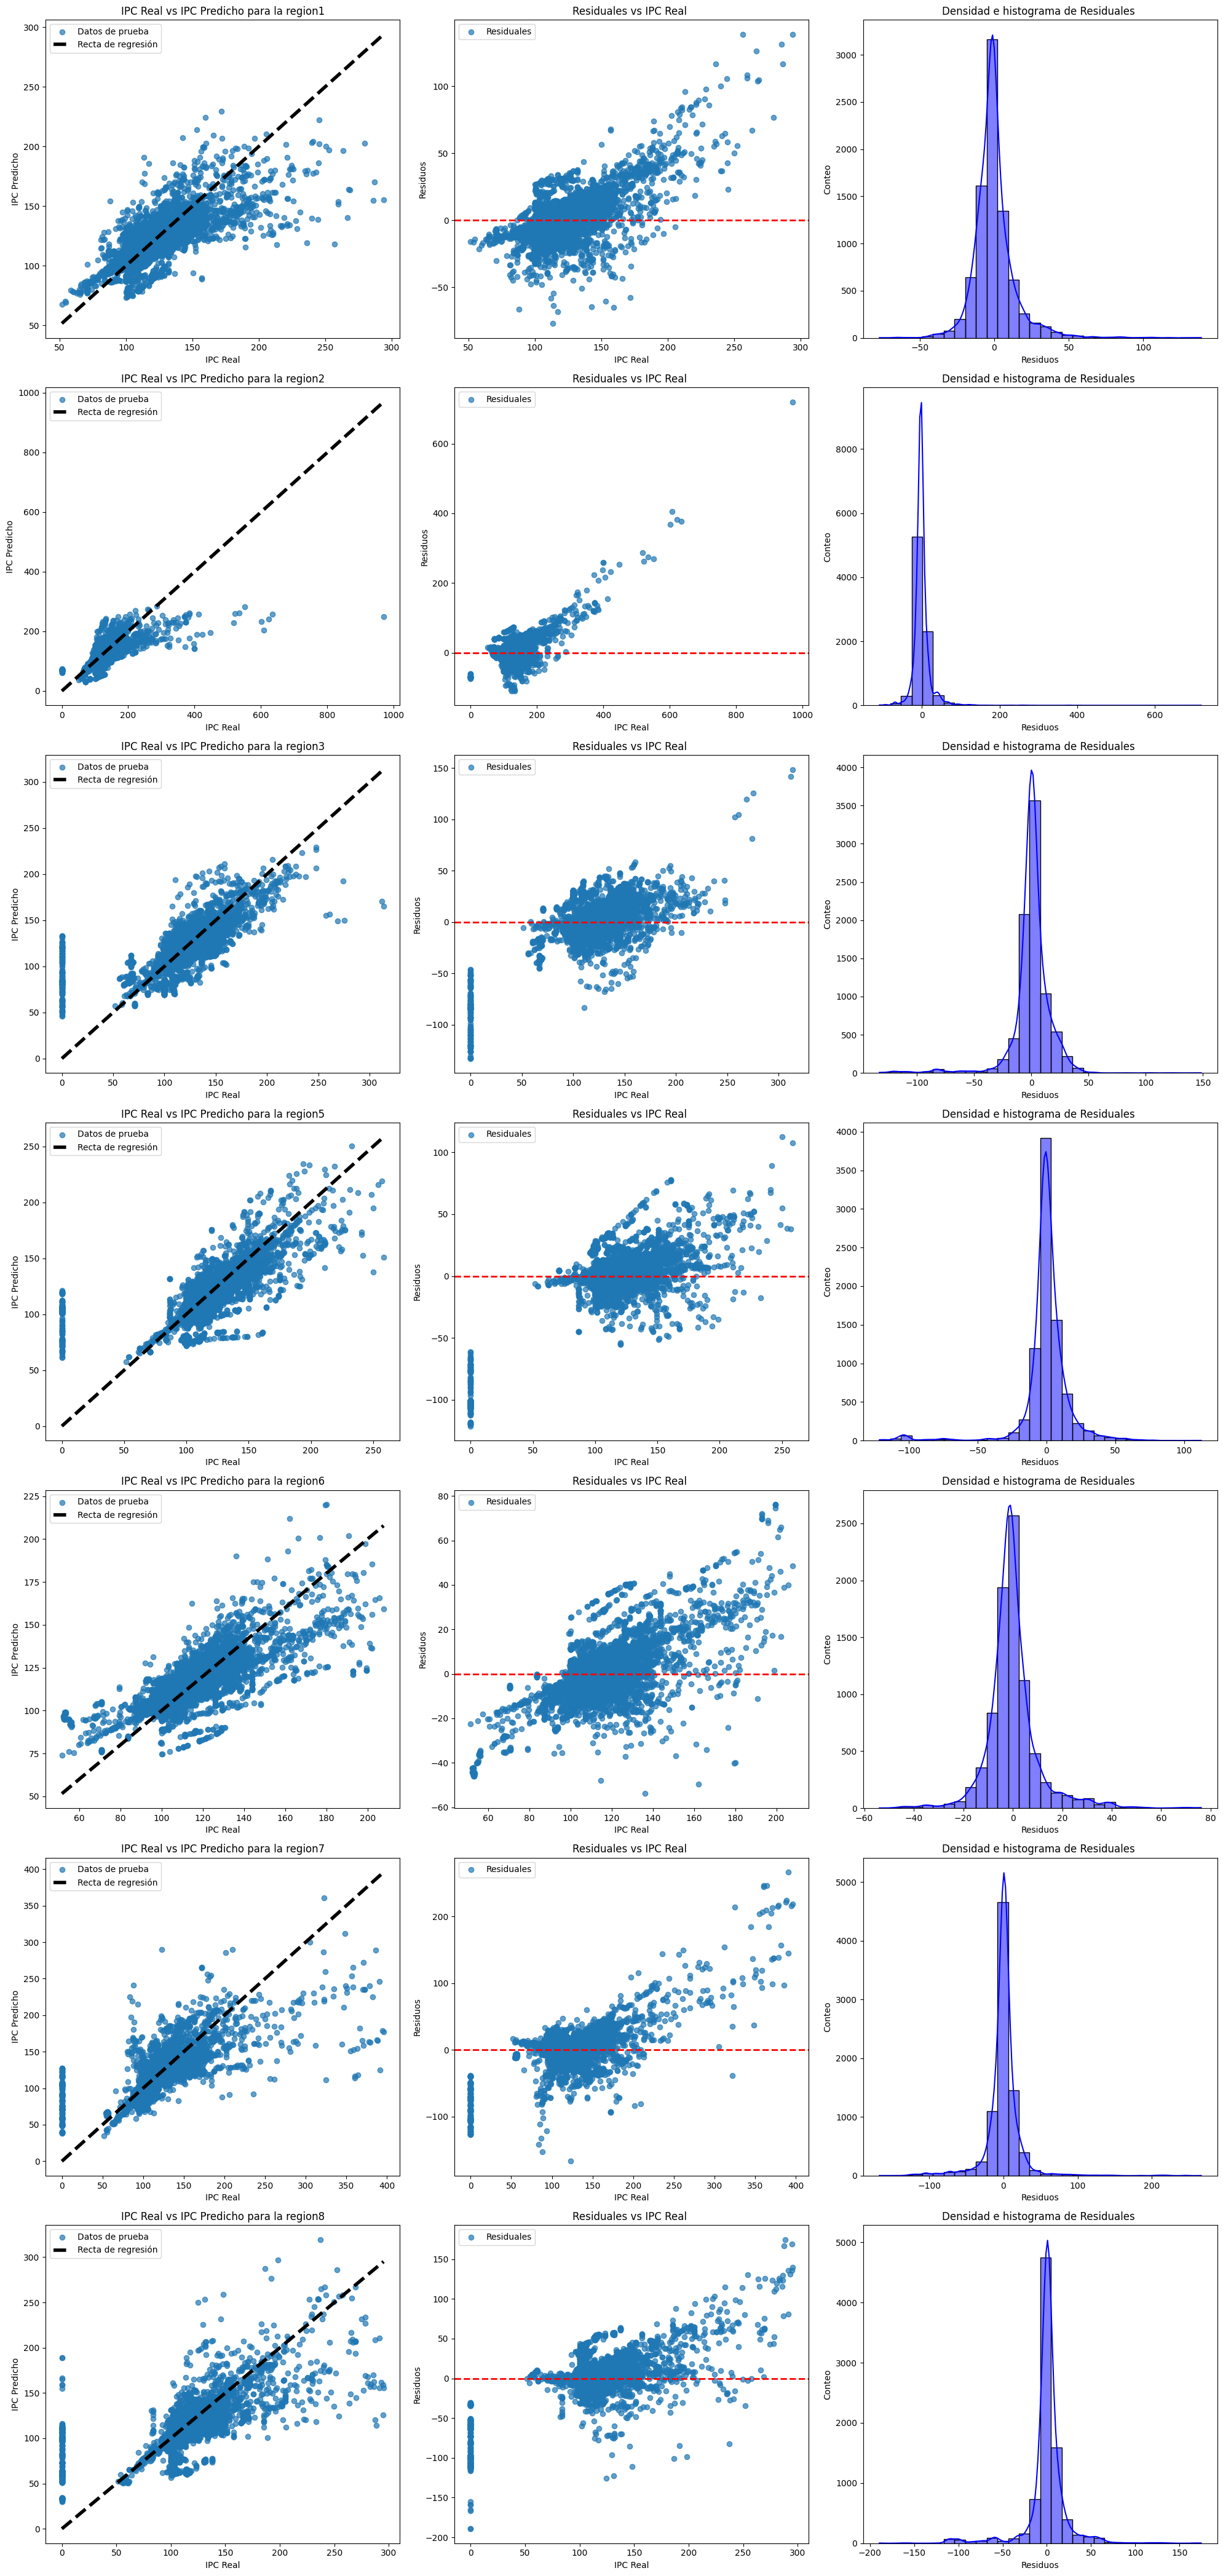

In [21]:
# Definir las regiones a predecir
regions = ['region1', 'region2', 'region3', 'region5', 'region6', 'region7', 'region8']
# Entrenar y evaluar modelos para diferentes regiones
region_models(data, regions)

**Transformacion de Data Original**

Es necesario transformar la data original para poder aplicarla a este otro modelo de regresión lineal, ya que en el análisis exploratorio se encontro que los valores de IPC por región no tienen alta correlación entre ellos, asimismo el modelo anterior claramente muestra que las regiones por si mismas no son buenas variables predictorias del IPC general de una región en especifico.
Por lo tanto se requiere convertir los productos y categorias como las variables para poder predecir de forma correcta el IPC general de una region en especifico.

**Pivotar la data**

In [22]:
def pivot_data_for_region(data, region_column):
    """
    Pivota los datos basándose en la columna de región especificada.

    Args:
        - data (DataFrame): DataFrame que contiene los datos que se van a pivotar.
        - region_column (str): Nombre de la columna que representa la región.

    Returns:
        - data_pivot (DataFrame): Tabla pivote con los datos agregados por región y tiempo.
    """
    # Crear una tabla pivote con los datos agregados por región y tiempo
    data_pivot = data.pivot_table(index=['anio', 'mes'], columns='codigo', values=region_column, aggfunc='mean')
    data_pivot.reset_index(inplace=True)
    # Eliminar las columnas de 'anio' y 'mes' del índice
    data_pivot = data_pivot.drop(columns=['anio', 'mes'])
    return data_pivot

**Manejar valores faltantes**

In [23]:
def process_ipc_data(region_data, missing_value_threshold=25):
    """
    Procesa los datos del IPC eliminando columnas con un alto porcentaje de valores faltantes e imputando los valores faltantes restantes con la media.

    Args:
        - region_data (DataFrame): Los datos del IPC para una región específica.
        - missing_value_threshold (float, opcional): El umbral porcentual de valores faltantes, por encima del cual se eliminarán las columnas. Por defecto, es 25.

    Returns:
        - imputed_data (DataFrame): Los datos del IPC procesados con los valores faltantes imputados.
    """
    # Calcular el porcentaje de valores faltantes en cada columna
    nan_counts = region_data.isna().sum()
    nan_percentage = (nan_counts / len(region_data)) * 100
    
    # Eliminar columnas con valores faltantes por encima del umbral
    columns_to_drop = nan_percentage[nan_percentage > missing_value_threshold].index
    reduced_data = region_data.drop(columns=columns_to_drop)
    
    # Imputar los valores faltantes restantes con la media
    imputed_data = reduced_data.fillna(reduced_data.mean())
    
    return imputed_data

**Entrenar el modelo y crear el split**

In [24]:
def train_model(region_data, test_size=0.2, random_state=0):
    """
    Entrena un modelo de regresión lineal utilizando los datos de región dados.

    Args:
        - region_data (DataFrame): Los datos de entrada que contienen las características y la variable objetivo.
        - test_size (float): La proporción de los datos a utilizar para la prueba (por defecto es 0.2).
        - random_state (int): La semilla aleatoria para reproducibilidad (por defecto es 0).

    Returns:
        - model (object): El modelo de regresión lineal entrenado.
        - X_test (DataFrame): Las características del conjunto de pruebas.
        - y_test (array): La variable objetivo del conjunto de pruebas.
    """
    # Seleccionar las características y la variable objetivo
    X = region_data.drop(columns=[0])
    y = region_data[0]
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Inicializar y entrenar el modelo
    model = LinearRegression()
    model.fit(X_train, y_train)

    return model, X_test, y_test

**Crear modelo para cada region**

In [25]:
def region_models_tr(data, features):
    """
    Entrena y evalúa modelos para diferentes regiones.

    Args:
        - data (DataFrame): Los datos de entrada que contienen los valores IPC para diferentes regiones.
        - features (list): La lista de regiones para entrenar modelos.

    Returns:
        - None
    """
    fig, axs = plt.subplots(len(features), 3, figsize=(20, 6 * len(features)))
    regions = {'region1': 'Metropolitana',
                        'region2': 'Norte',
                        'region3': 'Nororiental',
                        'region5': 'Central',
                        'region6': 'Suroccidental',
                        'region7': 'Noroccidental',
                        'region8': 'Petén'}
    for idx, region in enumerate(features):
        # Pivota los datos para la región
        region_data = pivot_data_for_region(data, region)
        # Procesa los datos de la región
        processed_data = process_ipc_data(region_data)
        # Entrena el modelo y obtiene los datos de prueba
        model, X_test, y_test = train_model(processed_data)
        # Obtener las predicciones y las métricas
        y_pred, mse, mae, r2 = get_metrics(model, X_test, y_test)

        print(f'\nRegión: {regions[region]}')
        show_metrics(mse, mae, r2)

        # Graficar predicciones, residuos y densidad de residuos
        plot_predictions(axs[idx, 0], y_test, y_pred, f'para la {region}')
        plot_residuals(axs[idx, 1], y_test, y_pred, f'para la {region}')
        residuals = y_test - y_pred
        plot_density_residuals(axs[idx, 2], residuals, f'para la {region}')
    
    plt.tight_layout()
    plt.show()


Región: Metropolitana
----------  Métricas  ----------
Mean Squared Error (MSE): 0.03310550745928664
Mean Absolute Error (MAE): 0.1306929028844519
R2 Score: 0.9996117860148703

Región: Norte
----------  Métricas  ----------
Mean Squared Error (MSE): 4.916485323583699
Mean Absolute Error (MAE): 1.7254458744483112
R2 Score: 0.9975063792768365

Región: Nororiental
----------  Métricas  ----------
Mean Squared Error (MSE): 0.04592116580397629
Mean Absolute Error (MAE): 0.1744092783433473
R2 Score: 0.9997650374338201

Región: Central
----------  Métricas  ----------
Mean Squared Error (MSE): 0.5117731839925539
Mean Absolute Error (MAE): 0.5220770234278973
R2 Score: 0.9969650893531821

Región: Suroccidental
----------  Métricas  ----------
Mean Squared Error (MSE): 0.4404411478179197
Mean Absolute Error (MAE): 0.40156925808842825
R2 Score: 0.9972842052027532

Región: Noroccidental
----------  Métricas  ----------
Mean Squared Error (MSE): 3.960090764641216
Mean Absolute Error (MAE): 1.39902

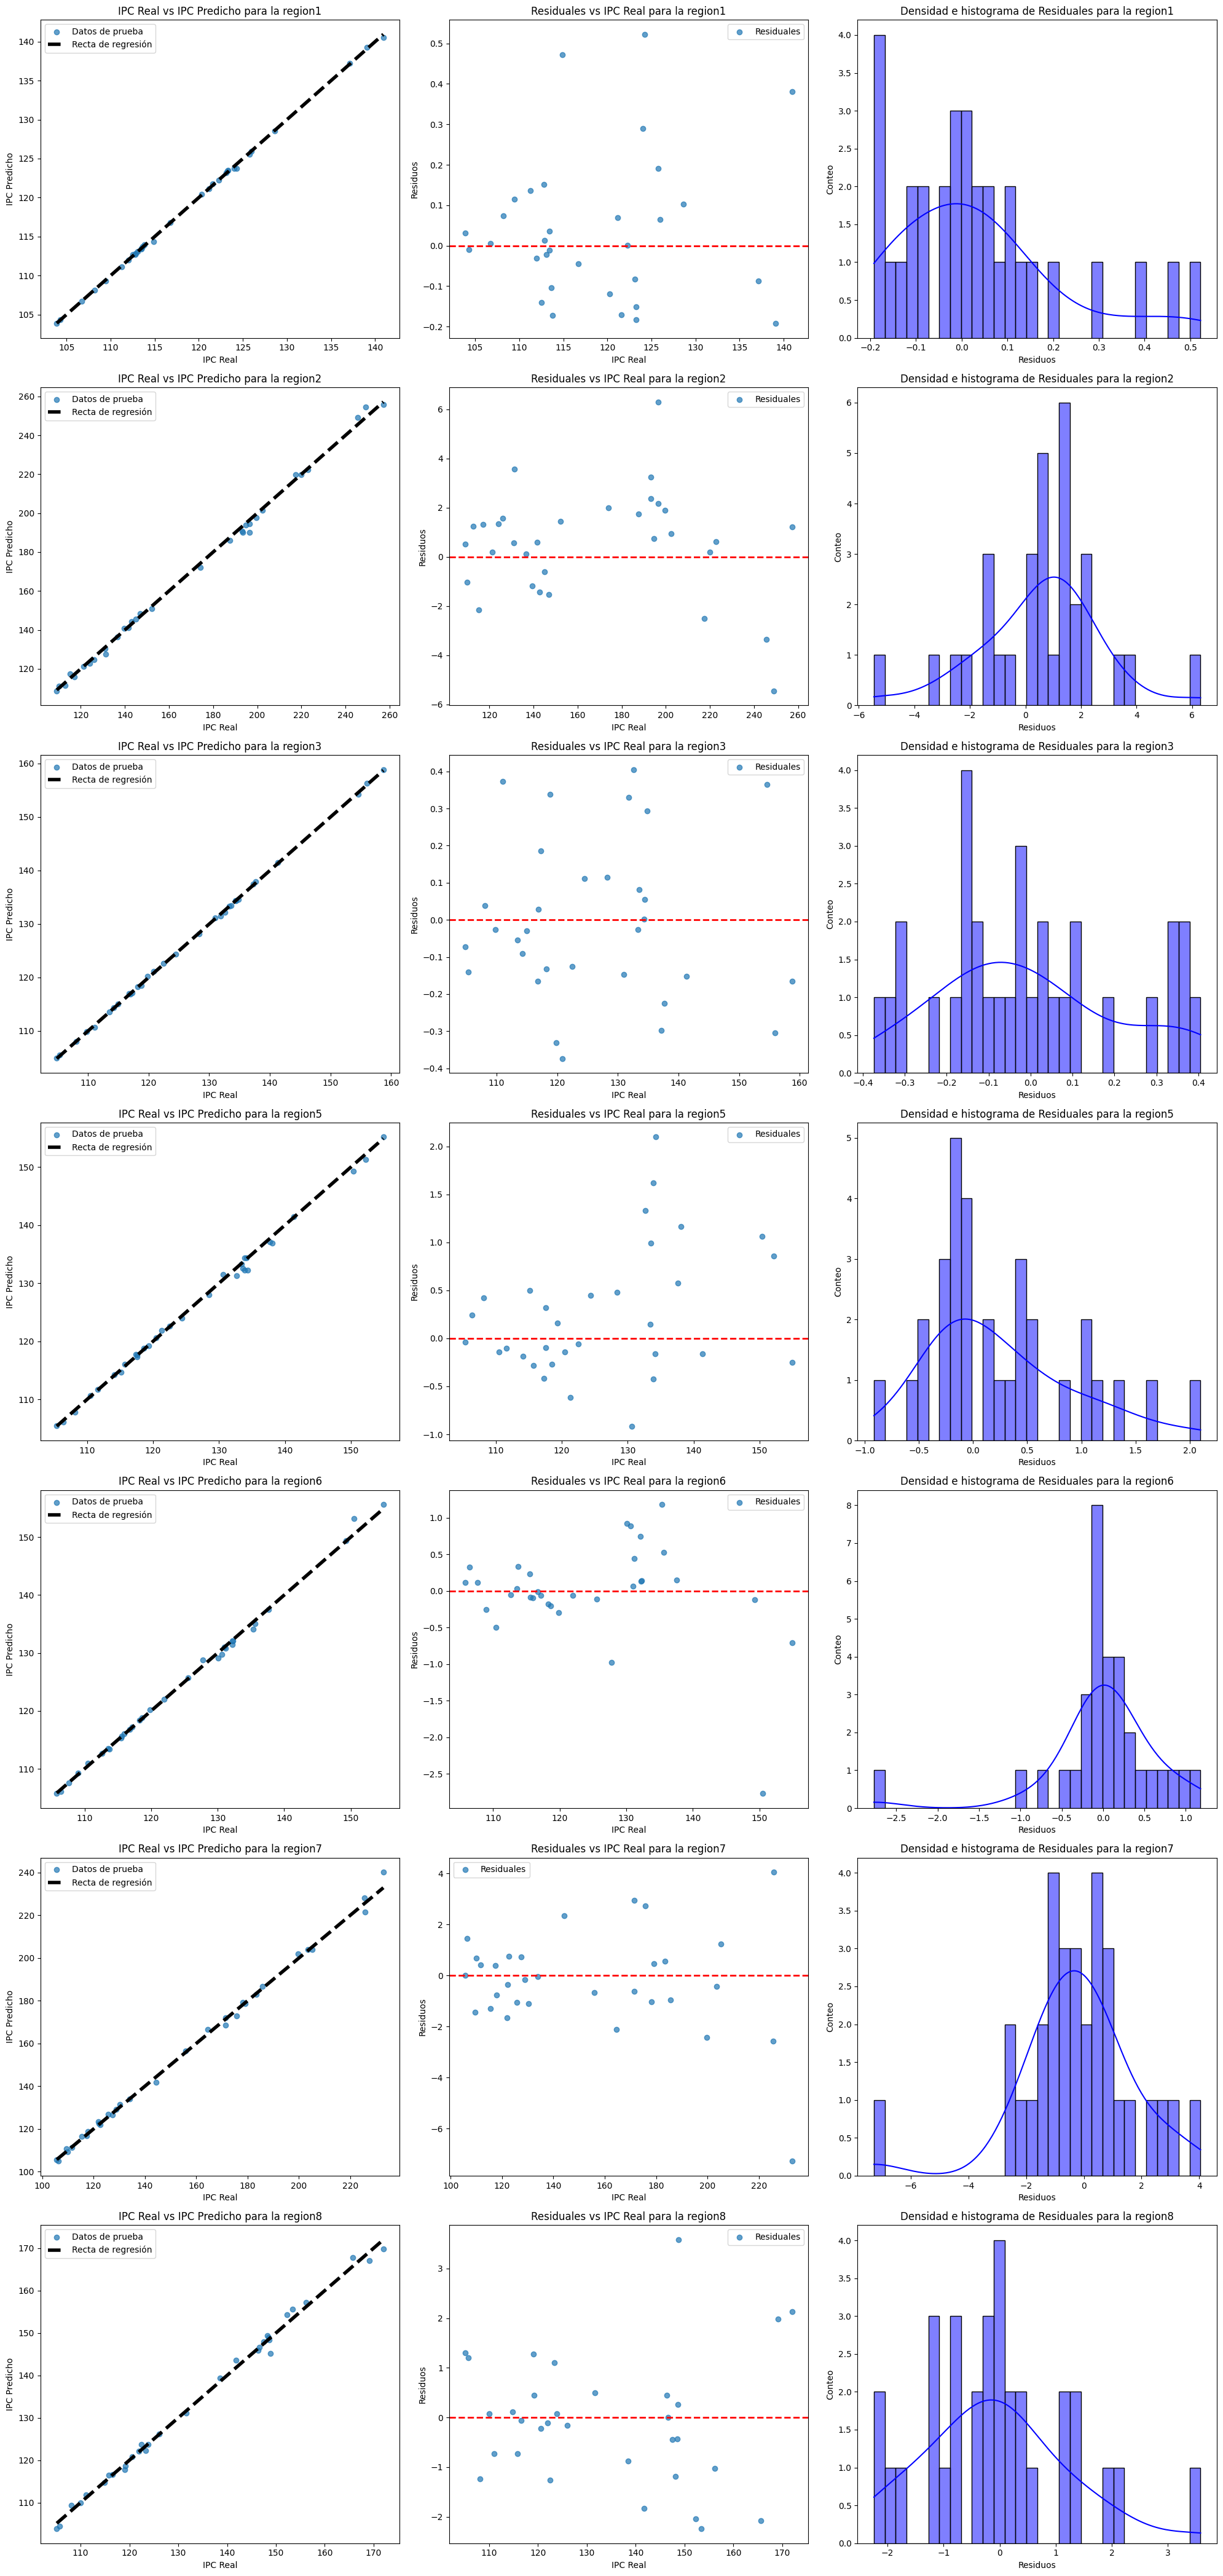

In [26]:
# Definir las regiones para entrenar los modelos
regions = ['region1', 'region2', 'region3', 'region5', 'region6', 'region7', 'region8']
# Entrenar y evaluar modelos para diferentes regiones
region_models_tr(data, regions)